In [1]:
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import dataset as ds
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split


/home/lai075/miniconda3/envs/PINN/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
# plot all images in the batch
def plot_images(images):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')


In [3]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.01
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

transforms = v2.Compose([
    v2.ToTensor(),
    v2.GaussianBlur(3, sigma=(0.1, 0.5)),
    #gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(90, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.CenterCrop(64),
])

torch.Size([1, 64, 64]) torch.Size([120])


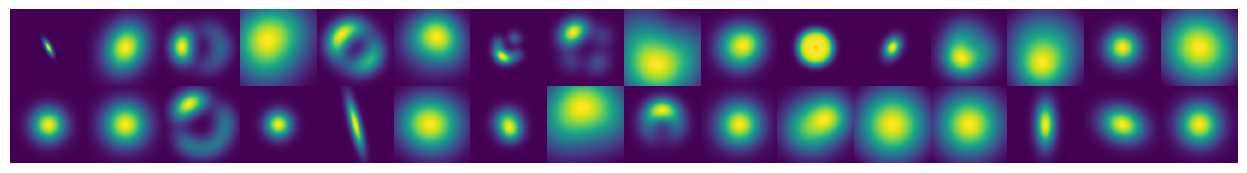

In [4]:
batch_size = 32

data_dir = 'datasets/'
mnames = ['gauss', 'disk', 'ring', 'mring', 'ellipse']
filenames = np.array([data_dir + 'imgs_' + m + '.npy' for m in mnames])

dataset = ds.ImgDataset(filenames, transform=transforms)
first = dataset[5000]
img, ci, class_label = first
print(img.shape, ci.shape)

# fig, ax = plt.subplots()
# ax.imshow(img.permute(1, 2, 0))

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val = DataLoader(val_data, batch_size=batch_size, shuffle=True)

if True:
    dataiter = iter(train)
    images, cis, classes = next(dataiter)

    plot_images(images)
        

In [5]:
# test decoder from ci
from torch import nn

test = np.random.random_sample((10, 120, 1, 1))

decoder = nn.Sequential(
    nn.ConvTranspose2d(120, 64, 4, 1, 0),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 32, 4, 2, 1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 4, 4, 2, 1),
)

out = decoder(torch.tensor(test, dtype=torch.float32))
print(out.shape)

test = np.random.random_sample((10, 120))

# turn it into a tensor of shape 120 x1 x1
test = torch.Tensor(test)
test = test.unsqueeze(2).unsqueeze(3)
print(test.shape)


torch.Size([10, 4, 16, 16])
torch.Size([10, 120, 1, 1])
